By Danilo Aballay, Federico Fuentes, Vicente Iligaray, Ángel J. Omella, David Pardo, Manuel A. Sánchez, Ignacio Tapia, Carlos Uriarte



In [1]:
# Import libraries
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

os.environ["KERAS_BACKEND"] = "jax"

import keras

from fem_system import solve_and_loss, solve
from r_adaptivity_NN import make_model, make_loss_model, lr_schedule, tricky_loss

# Set the random seed
np.random.seed(1234)
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)

/home/vicente/miniconda3/envs/course/lib/python3.12/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Create the model
# Number of neurons 
nn = 2*17
# Number of training iterations
iterations = 1500

# Initialize the neural network model for the approximate solution
model = make_model(nn)
# Save initial nodes
init_nodes = model(jnp.array([1]))
# Create loss model
loss_model = make_loss_model(model)
# Optimizer (Adam optimizer with a specific learning rate)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
# Learning rate schedule
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
# Compile the loss model with a custom loss function (tricky_loss)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

In [3]:
# Train the model
start_time = time.time()
history    = loss_model.fit(jnp.array([1.]), jnp.array([1.]), epochs=iterations, callbacks = [lr_scheduler], verbose=0)
end_time   = time.time() 
print('Training time: ', end_time - start_time)

Training time:  20.99702739715576


e_h: 0.12667744330023029
e_theta: 0.11784110558861546


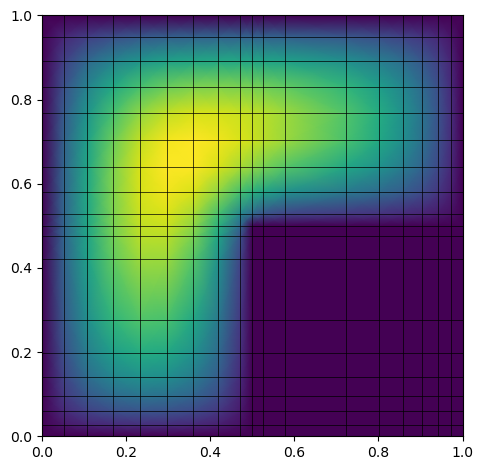

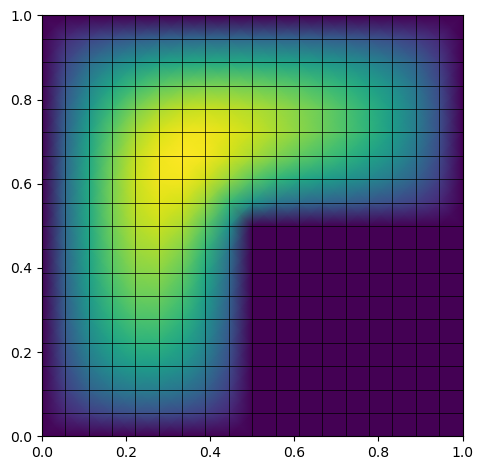

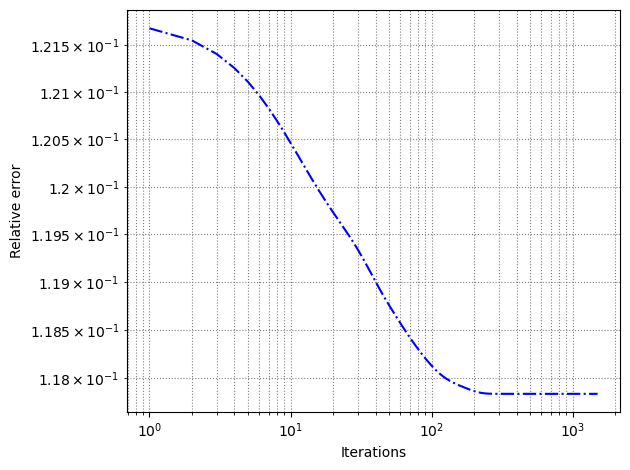

In [4]:
# Plot results
uniform_nodes = jnp.concatenate([jnp.linspace(0, 1, nn//2 + 2), jnp.linspace(0, 1, nn//2 + 2)])

node_coords, u = solve(model(jnp.array([1])))
uniform_coords, o = solve(uniform_nodes)

J_u_theta = np.array(history.history['loss'])
J_u       = -0.00668986
J_u_h = solve_and_loss(uniform_nodes)
rel_error_theta = np.sqrt((J_u - J_u_theta)/J_u)
rel_error_h = np.sqrt((J_u - J_u_h)/J_u)
print('e_h:', rel_error_h)
print('e_theta:', rel_error_theta[-1])

# Plot the approximate solution obtained from the trained model
plt.figure(1)
plt.pcolormesh(node_coords[:,0].reshape(nn//2+2,nn//2+2), node_coords[:,1].reshape(nn//2+2,nn//2+2), u.reshape(nn//2+2,nn//2+2), shading='gouraud')
unique_x = np.unique(node_coords[:,0])
unique_y = np.unique(node_coords[:,1])
for xi in unique_x:
    plt.plot([xi] * len(unique_y), unique_y, color='black', linewidth=0.5)
for yi in unique_y:
    plt.plot(unique_x, [yi] * len(unique_x), color='black', linewidth=0.5) 
plt.gca().set_aspect('equal')
plt.tight_layout()

# Plot the approximate solution obtained from the uniform mesh
plt.figure(2)
plt.pcolormesh(uniform_coords[:,0].reshape(nn//2+2,nn//2+2), uniform_coords[:,1].reshape(nn//2+2,nn//2+2), o.reshape(nn//2+2,nn//2+2), shading='gouraud')
unique_x = np.unique(uniform_coords[:,0])
unique_y = np.unique(uniform_coords[:,1])
for xi in unique_x:
    plt.plot([xi] * len(unique_y), unique_y, color='black', linewidth=0.5)
for yi in unique_y:
    plt.plot(unique_x, [yi] * len(unique_x), color='black', linewidth=0.5) 
plt.gca().set_aspect('equal')
plt.tight_layout()

# Plot the relative error
plt.figure(3)
plt.loglog(np.arange(1,iterations+1), rel_error_theta,'-.', color='b')
plt.xlabel('Iterations')
plt.ylabel('Relative error')
plt.grid(which = 'both', axis = 'both', linestyle = ':', color = 'gray')
plt.tight_layout()

plt.show()

In [5]:
from fem_system import generate_mesh

def get_grad(node_coords, u):
    x = jnp.unique(node_coords[:,0])
    y = jnp.unique(node_coords[:,1])
    nx = len(x)
    ny = len(y)

    coords, elements = generate_mesh(nx, ny, x, y)

    u_elements = jnp.zeros(elements.shape, dtype=jnp.float64)
    u_elements = u_elements.at[:, 0].set(u[elements[:, 0]])
    u_elements = u_elements.at[:, 1].set(u[elements[:, 1]])
    u_elements = u_elements.at[:, 2].set(u[elements[:, 2]])
    u_elements = u_elements.at[:, 3].set(u[elements[:, 3]])
    nodes_int = jnp.array([-1, 1], dtype=jnp.float64)

    def element_grad(coords, coefs):
        x1, y1, x2, y2   = coords
        hx, hy = x2 - x1, y2 - y1
        transf_nodes_x = jnp.array([x1,x2],dtype=jnp.float64)
        transf_nodes_y = jnp.array([y1,y2],dtype=jnp.float64)
        X, Y = jnp.meshgrid(nodes_int, nodes_int)
        Xt, Yt = jnp.meshgrid(transf_nodes_x, transf_nodes_y)
        

        gradphi0 = lambda x, y: jnp.array([-0.25 * (1 - y) * (2/hx), -0.25 * (1 - x) * (2/hy)])
        gradphi1 = lambda x, y: jnp.array([0.25 * (1 - y) * (2/hx), -0.25 * (1 + x) * (2/hy)])
        gradphi2 = lambda x, y: jnp.array([0.25 * (1 + y) * (2/hx), 0.25 * (1 + x) * (2/hy)])
        gradphi3 = lambda x, y: jnp.array([-0.25 * (1 + y) * (2/hx), 0.25 * (1 - x) * (2/hy)])

        gradphi0_vals = gradphi0(X, Y)
        gradphi1_vals = gradphi1(X, Y)
        gradphi2_vals = gradphi2(X, Y)
        gradphi3_vals = gradphi3(X, Y)

        grad = coefs[0] * gradphi0_vals + coefs[1] * gradphi1_vals + coefs[2] * gradphi2_vals + coefs[3] * gradphi3_vals

        return grad, jnp.stack([Xt.ravel(), Yt.ravel()], axis=1)

    midpts = 0.5*(node_coords[elements[:,0]] + node_coords[elements[:,2]])
    mask = ~((midpts[:,0] > 0.5) & (midpts[:,1] < 0.5))


    coords_corners = jnp.concatenate([node_coords[elements[mask,0]], node_coords[elements[mask,2]]], axis=1)
    grad, nodes = jax.vmap(element_grad, in_axes=(0, 0))(coords_corners, u_elements[mask])

    gx = grad[:, 0, :, :].reshape(-1)
    gy = grad[:, 1, :, :].reshape(-1)
    ndsx = nodes[:, :, 0].reshape(-1)
    ndsy = nodes[:, :, 1].reshape(-1)
    gx.shape[0]

    gradx = jnp.zeros((coords.shape[0],2), dtype=jnp.float64)
    grady = jnp.zeros((coords.shape[0],2), dtype=jnp.float64)

    for i in range(gx.shape[0]):
        nod = jnp.array([ndsx[i],ndsy[i]])
        index = jnp.linalg.norm(coords-nod,axis=1).argmin().item()
        gradx = gradx.at[index,0].set(gradx[index,0]+gx[i])
        gradx = gradx.at[index,1].set(gradx[index,1]+1)
        grady = grady.at[index,0].set(grady[index,0]+gy[i])
        grady = grady.at[index,1].set(grady[index,1]+1)
    gradx = gradx[:,0]/gradx[:,1]
    grady = grady[:,0]/grady[:,1]

    mask = (coords[:,0]>0.5) & (coords[:,1]<0.5)
    gradnorm = jnp.sqrt(gradx**2 + grady**2)
    # gradnorm = gradnorm.at[mask].set(0)

    return gradnorm

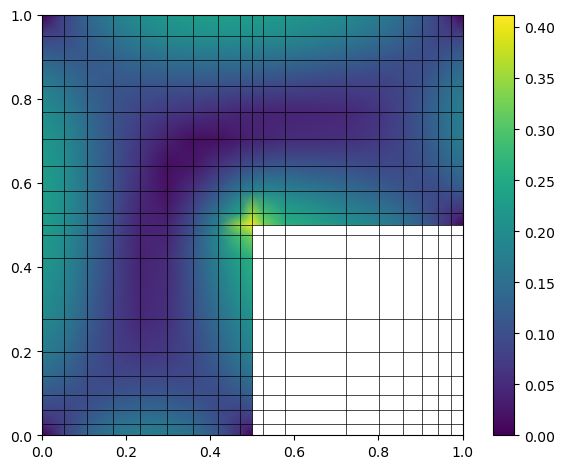

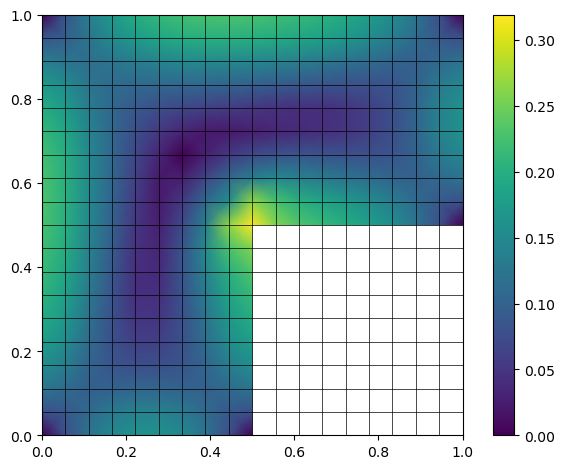

In [6]:
# Plot gradnorm

# Plot the approximate solution obtained from the trained model
plt.figure(1)
gradnorm_adp = get_grad(node_coords, u)
plt.pcolormesh(node_coords[:,0].reshape(nn//2+2,nn//2+2), node_coords[:,1].reshape(nn//2+2,nn//2+2), gradnorm_adp.reshape(nn//2+2,nn//2+2), shading='gouraud')
unique_x = np.unique(node_coords[:,0])
unique_y = np.unique(node_coords[:,1])
for xi in unique_x:
    plt.plot([xi] * len(unique_y), unique_y, color='black', linewidth=0.5)
for yi in unique_y:
    plt.plot(unique_x, [yi] * len(unique_x), color='black', linewidth=0.5) 
plt.colorbar()
plt.gca().set_aspect('equal') 
plt.tight_layout()

# Plot the approximate solution obtained from the uniform mesh
plt.figure(2)
gradnorm_uniform = get_grad(uniform_coords, o)
plt.pcolormesh(uniform_coords[:,0].reshape(nn//2+2,nn//2+2), uniform_coords[:,1].reshape(nn//2+2,nn//2+2), gradnorm_uniform.reshape(nn//2+2,nn//2+2), shading='gouraud')
unique_x = np.unique(uniform_coords[:,0])
unique_y = np.unique(uniform_coords[:,1])
for xi in unique_x:
    plt.plot([xi] * len(unique_y), unique_y, color='black', linewidth=0.5)
for yi in unique_y:
    plt.plot(unique_x, [yi] * len(unique_x), color='black', linewidth=0.5) 
plt.colorbar()
plt.gca().set_aspect('equal')
plt.tight_layout()

plt.show()